In [1]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_csv('STB.csv')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,06/01/2018,11750,11700,12000,11700,4.31M,0.0000
1,06/04/2018,12550,12000,12550,12000,7.42M,0.0681
2,06/05/2018,12900,12700,13150,12600,8.11M,0.0279
3,06/06/2018,13300,12800,13450,12700,8.48M,0.0310
4,06/07/2018,13000,13300,13350,12950,7.11M,-0.0226


In [3]:
# Take AR Model of lag = 3, 2 differencing for stationary
train_size = int(0.5 * len(df))
test_size = len(df) - train_size

train_data = df['Price'].iloc[:train_size]
test_data =  df['Price'].iloc[train_size:]

In [4]:
from pmdarima.arima import auto_arima
best_arima = auto_arima(train_data,trace=True)
best_arima.fit(train_data)
print(best_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8557.783, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8561.591, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8563.518, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8563.741, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8559.759, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8565.723, Time=0.50 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8565.944, Time=0.58 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8561.914, Time=0.86 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8564.985, Time=0.44 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8566.103, Time=0.78 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8566.726, Time=0.82 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=8555.906, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=8

In [5]:
# summary of fit model
arimax_train = df[['Price','High']].iloc[:train_size]
arimax_test = df[['Price','High']].iloc[train_size:]
arimax_model = ARIMA(arimax_train['Price'],exog=arimax_train['High'],order=(2,1,2))
arimax_fitted = arimax_model.fit()
print(arimax_fitted.summary())

C:\Users\giangle\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\giangle\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  621
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3923.114
Date:                Fri, 16 Jun 2023   AIC                           7858.227
Time:                        22:15:45   BIC                           7884.805
Sample:                             0   HQIC                          7868.558
                                - 621                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
High           0.9597      0.008    123.927      0.000       0.945       0.975
ar.L1          0.5590      0.160      3.484      0.000       0.245       0.873
ar.L2          0.1509      0.037      4.114      0.0

In [6]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data)
y_pred_arimax= arimax_fitted.predict(start=len(df)-test_size,end=len(df)-1,exog= arimax_test['High'])

# 5. Quá trình Validate
x_val= np.array(df['Price'].index).reshape(-1, 1)
y_val = np.array(df['Price'])
y_pred_val_arimax =  arimax_fitted.predict(start=0,end=train_size-1,exog=arimax_train['High'])
y_pred_val_arimax = pd.concat([y_pred_val_arimax,y_pred_arimax])

ARIMAX Validation RMSE: 367.73766674512217
ARIMAX Testing RMSE: 502.009429928012
Validation MAPE: 1.2547606378599818
Testing MAPE: 1.661629479388533
Validation MAE: 254.32217379042905
Testing MAE: 412.47685090617756


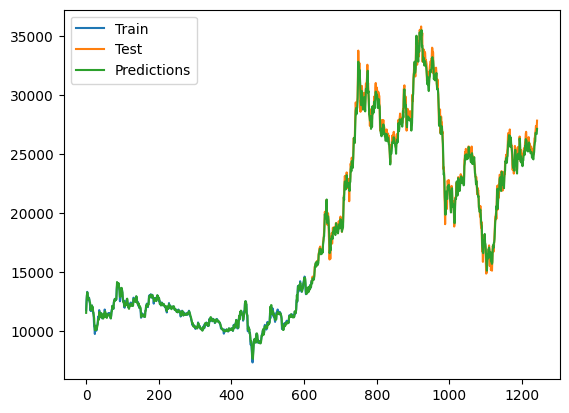

In [7]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val_arimax - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred_arimax - y_test)**2))
print('ARIMAX Validation RMSE:', valid_rmse)
print('ARIMAX Testing RMSE:', test_rmse)

valid_mape = np.mean(np.abs((y_pred_val_arimax - y_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_pred_arimax - y_test) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

valid_mae = np.mean(np.abs(y_pred_val_arimax - y_val))
test_mae = np.mean(np.abs(y_pred_arimax - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

# 9.Vẽ hình
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(df['Price'].index, y_pred_val_arimax)
# plt.plot(last_data,y_next_10_arima)
plt.legend(['Train', 'Test', 'Predictions','Validate'])
plt.show()